---
# 🟢 Lab 5: Find All Objects & Label with Text Prompts

##  Theory

In previous labs, we manually specified **which** concept to find (text prompt)
or **where** to look (point/box prompt). But what if we want to automatically
discover and label **every object** in an image?

### Strategy: Two-Stage Pipeline

SAM 3 combines two powerful capabilities:

1. **Automatic Mask Generation (AMG):** Generate masks for ALL objects in the image
   without any prompt — the model proposes candidate regions automatically.
2. **Text Prompt Matching (PCS):** For each candidate region, use text prompts
   to identify what the object is by scoring concept presence.

```
┌─────────────────────────────────────────────────────────────┐
│                    Two-Stage Pipeline                       │
│                                                             │
│  Stage 1: Find ALL objects (Automatic Mask Generation)      │
│  ┌─────────┐    ┌──────────────┐    ┌──────────────────┐   │
│  │  Image   │───▶│ SAM3 AMG     │───▶│ N mask proposals │   │
│  └─────────┘    │ (no prompt)  │    │ + bounding boxes │   │
│                  └──────────────┘    └────────┬─────────┘   │
│                                               │             │
│  Stage 2: Label each object (Text Prompts)    │             │
│  ┌──────────────┐    ┌──────────────┐         ▼             │
│  │ Candidate    │    │ SAM3 PCS     │    ┌──────────┐       │
│  │ label list   │───▶│ text prompts │───▶│ Labeled  │       │
│  │ (103 foods)  │    │ per crop     │    │ objects  │       │
│  └──────────────┘    └──────────────┘    └──────────┘       │
└─────────────────────────────────────────────────────────────┘
```

### Why Two Stages?

| Approach | Pros | Cons |
|---|---|---|
| **Text prompt per class** | Simple API | Must loop over ALL 103 classes — very slow |
| **AMG + Text scoring** | Finds unknown objects first, then labels | Two steps, but much faster overall |
| **AMG only** | Fastest | No labels — just anonymous masks |

### Key Concept: Automatic Mask Generation (AMG)

AMG works by sampling a dense grid of point prompts across the image
and collecting all the predicted masks. It then applies Non-Maximum
Suppression (NMS) to remove duplicates, producing a clean set of
non-overlapping object proposals.

**AMG Parameters:**
| Parameter | Description | Default |
|---|---|---|
| `points_per_side` | Grid density for point sampling | 32 |
| `pred_iou_thresh` | Minimum IoU score to keep a mask | 0.88 |
| `stability_score_thresh` | Minimum stability to keep a mask | 0.95 |
| `min_mask_region_area` | Minimum mask area in pixels | 0 |

---
## 5A: Automatic Mask Generation — Find All Objects

First, let's use SAM 3 Tracker to generate masks for ALL objects
in a food image without specifying any text prompt.

In [1]:
# Step 5A.1: Setup Automatic Mask Generator
# We use Sam3TrackerModel with the automatic mask generation pipeline

from transformers import Sam3TrackerProcessor, Sam3TrackerModel, pipeline
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image as PILImage
from datasets import load_dataset
from scipy import ndimage

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load tracker model (same as Lab 3/4)
tracker_processor = Sam3TrackerProcessor.from_pretrained("facebook/sam3")
tracker_model = Sam3TrackerModel.from_pretrained("facebook/sam3").to(device)
tracker_model.eval()

print("load model tracker already")

You are using a model of type sam3_video to instantiate a model of type sam3_tracker. This is not supported for all configurations of models and can yield errors.


Loading weights:   0%|          | 0/685 [00:00<?, ?it/s]

load model tracker already


In [2]:

# Load PCS model (same as Lab 2) for text-based labeling
from transformers import Sam3Processor, Sam3Model

processor = Sam3Processor.from_pretrained("facebook/sam3")
model = Sam3Model.from_pretrained("facebook/sam3").to(device)
model.eval()


print("load model sam3 already")

Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

load model sam3 already


In [3]:
# Load dataset
ds = load_dataset("EduardoPacheco/FoodSeg103", split="train")

# FoodSeg103 class labels
FOODSEG103_LABELS = {
    0: "background", 1: "candy", 2: "egg tart", 3: "french fries", 4: "chocolate",
    5: "biscuit", 6: "popcorn", 7: "pudding", 8: "ice cream", 9: "cheese butter",
    10: "cake", 11: "wine", 12: "milkshake", 13: "coffee", 14: "juice",
    15: "milk", 16: "tea", 17: "almond", 18: "red beans", 19: "cashew",
    20: "dried cranberries", 21: "soy", 22: "walnut", 23: "peanut", 24: "egg",
    25: "apple", 26: "date", 27: "apricot", 28: "avocado", 29: "banana",
    30: "strawberry", 31: "cherry", 32: "blueberry", 33: "raspberry", 34: "mango",
    35: "olives", 36: "peach", 37: "lemon", 38: "pear", 39: "fig",
    40: "pineapple", 41: "grape", 42: "kiwi", 43: "melon", 44: "orange",
    45: "watermelon", 46: "steak", 47: "pork", 48: "chicken duck", 49: "sausage",
    50: "fried meat", 51: "lamb", 52: "sauce", 53: "crab", 54: "fish",
    55: "shellfish", 56: "shrimp", 57: "squid", 58: "bread", 59: "corn",
    60: "dumpling", 61: "hamburger", 62: "pizza", 63: "hanamaki baozi",
    64: "wonton", 65: "pasta", 66: "rice", 67: "noodles", 68: "soup",
    69: "cake", 70: "hotdog", 71: "spring roll", 72: "tofu", 73: "asparagus",
    74: "broccoli", 75: "Brussels sprout", 76: "cabbage", 77: "carrot",
    78: "celery", 79: "corn", 80: "cucumber", 81: "eggplant",
    82: "garlic", 83: "ginger", 84: "lettuce", 85: "mushroom",
    86: "onion", 87: "pepper", 88: "potato", 89: "pumpkin",
    90: "sweet potato", 91: "tomato", 92: "bean sprouts", 93: "green beans",
    94: "spinach", 95: "bell pepper", 96: "white radish", 97: "kidney beans",
    98: "mixed vegetables", 99: "crispy chicken", 100: "chicken wings",
    101: "french beans", 102: "other ingredients", 103: "salad"
}

print(f"✅ All models loaded on {device}")

✅ All models loaded on cuda


In [4]:
# Step 5A.2: Automatic Mask Generation using grid-based point sampling
#
# SAM 3 Tracker doesn't have a built-in "generate everything" mode in the
# HuggingFace API, so we implement AMG by:
#   1. Sampling a grid of points across the image
#   2. Running each point as a single-point prompt
#   3. Collecting all masks and applying NMS to remove duplicates

def generate_point_grid(img_w, img_h, points_per_side=16):
    """Generate a uniform grid of point coordinates over the image."""
    xs = np.linspace(0, img_w - 1, points_per_side).astype(int)
    ys = np.linspace(0, img_h - 1, points_per_side).astype(int)
    points = []
    for y in ys:
        for x in xs:
            points.append([int(x), int(y)])
    return points


def compute_mask_iou(mask1, mask2):
    """Compute IoU between two binary masks."""
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0.0


def automatic_mask_generation(
    image, tracker_processor, tracker_model, device,
    points_per_side=16,
    pred_iou_thresh=0.80,
    min_mask_region_area=500,
    nms_iou_thresh=0.5
):
    """
    Automatic Mask Generation (AMG) for SAM 3.

    Strategy:
    1. Sample a grid of points across the image
    2. Run single-point prompts for each grid point
    3. Keep masks above IoU score threshold
    4. Remove duplicates with Non-Maximum Suppression (NMS)

    Args:
        image: PIL Image (RGB)
        tracker_processor: Sam3TrackerProcessor
        tracker_model: Sam3TrackerModel
        device: torch device
        points_per_side: Grid density (N x N points)
        pred_iou_thresh: Minimum predicted IoU score to keep a mask
        min_mask_region_area: Minimum mask area in pixels
        nms_iou_thresh: IoU threshold for NMS deduplication

    Returns:
        List of dicts with keys: 'mask', 'score', 'bbox', 'area', 'point'
    """
    img_w, img_h = image.size
    grid_points = generate_point_grid(img_w, img_h, points_per_side)

    print(f"🔍 AMG: Sampling {len(grid_points)} grid points ({points_per_side}x{points_per_side})...")

    # Stage 1: Collect candidate masks from all grid points
    candidates = []

    for i, pt in enumerate(grid_points):
        input_points = [[[[pt[0], pt[1]]]]]
        input_labels = [[[1]]]

        inputs = tracker_processor(
            images=image,
            input_points=input_points,
            input_labels=input_labels,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = tracker_model(**inputs)

        masks = outputs.pred_masks.squeeze().cpu().numpy()
        scores = outputs.iou_scores.squeeze().cpu().numpy()

        # Take the best mask for this point
        best_idx = scores.argmax()
        best_mask = masks[best_idx]
        best_score = float(scores[best_idx])

        # Resize mask to original image size
        best_mask_resized = np.array(
            PILImage.fromarray(best_mask.astype(np.float32)).resize((img_w, img_h))
        ) > 0

        area = int(best_mask_resized.sum())

        # Filter by score and area
        if best_score >= pred_iou_thresh and area >= min_mask_region_area:
            # Compute bounding box from mask
            ys, xs = np.where(best_mask_resized)
            bbox = [int(xs.min()), int(ys.min()), int(xs.max()), int(ys.max())]

            candidates.append({
                'mask': best_mask_resized,
                'score': best_score,
                'bbox': bbox,
                'area': area,
                'point': pt
            })

    print(f"   Candidates after score/area filter: {len(candidates)}")

    # Stage 2: Non-Maximum Suppression (NMS) to remove duplicates
    # Sort by score descending
    candidates.sort(key=lambda x: x['score'], reverse=True)

    keep = []
    used = [False] * len(candidates)

    for i in range(len(candidates)):
        if used[i]:
            continue
        keep.append(candidates[i])
        used[i] = True

        for j in range(i + 1, len(candidates)):
            if used[j]:
                continue
            iou = compute_mask_iou(candidates[i]['mask'], candidates[j]['mask'])
            if iou > nms_iou_thresh:
                used[j] = True  # Suppress duplicate

    print(f"   Final masks after NMS: {len(keep)}")
    return keep

In [5]:
# Step 5A.3: Run AMG on a food image

sample = ds[2629]
image = sample['image'].convert("RGB")
img_w, img_h = image.size
label_array = np.array(sample['label'])
gt_classes = sample['classes_on_image']
gt_class_names = [FOODSEG103_LABELS.get(c, f"class_{c}") for c in gt_classes]

print(f"Image size: {img_w} x {img_h}")
print(f"Ground truth classes: {gt_class_names}")
print()

# Run Automatic Mask Generation
amg_results = automatic_mask_generation(
    image, tracker_processor, tracker_model, device,
    points_per_side=16,       # 16x16 = 256 point probes
    pred_iou_thresh=0.80,     # Keep masks with score > 0.80
    min_mask_region_area=500, # Ignore tiny regions < 500 pixels
    nms_iou_thresh=0.5        # Remove masks overlapping > 50%
)

print(f"\n✅ Found {len(amg_results)} objects automatically!")

Image size: 410 x 307
Ground truth classes: ['background', 'lemon', 'steak', 'bread', 'corn', 'asparagus', 'lettuce']

🔍 AMG: Sampling 256 grid points (16x16)...
   Candidates after score/area filter: 201
   Final masks after NMS: 15

✅ Found 15 objects automatically!


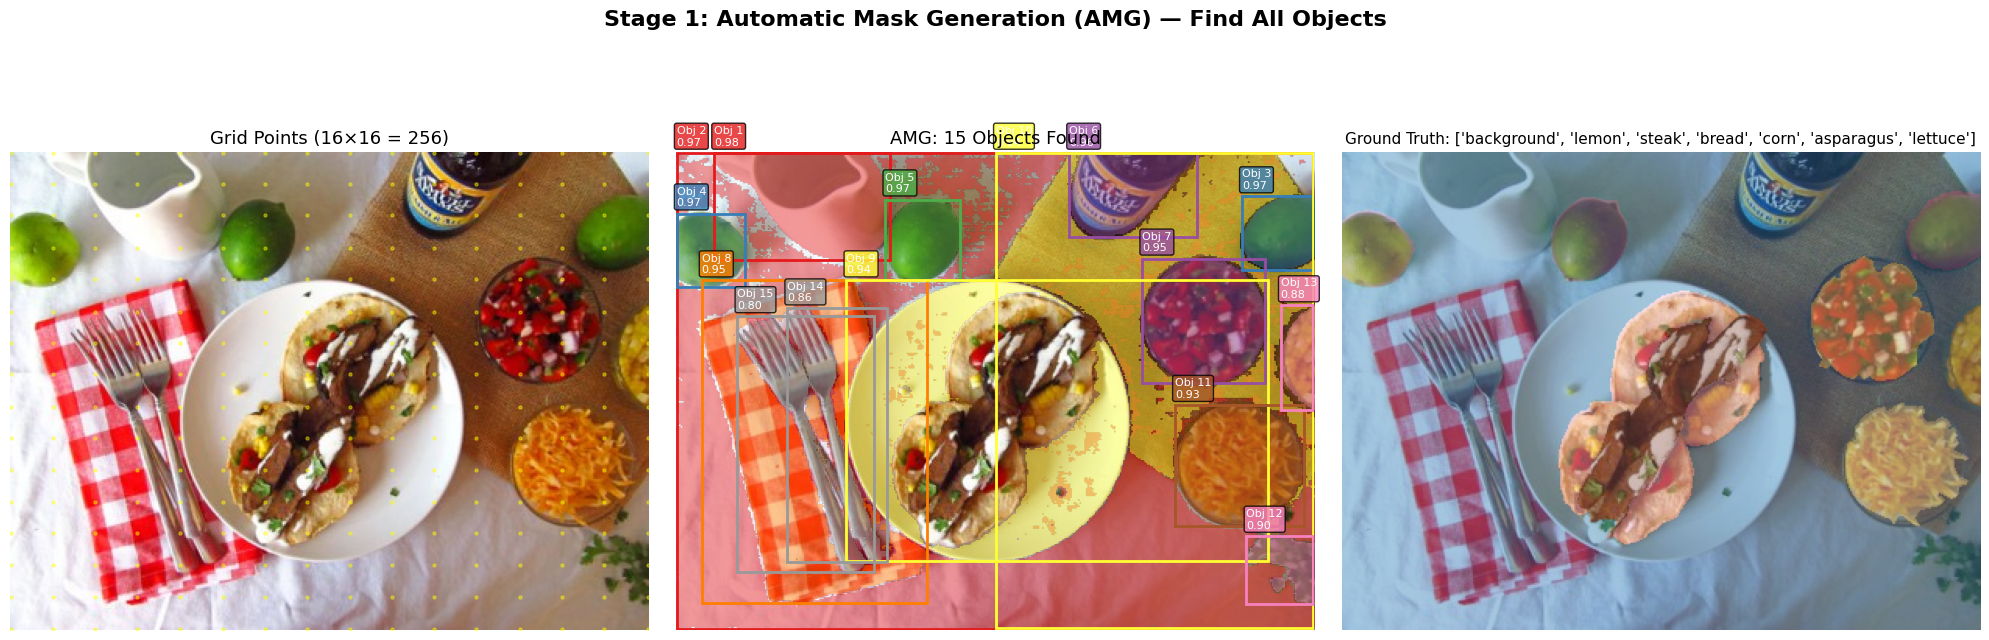


Obj   Score    Area (px)    BBox                      Seed Point     
-----------------------------------------------------------------
1     0.9790   5,351        [24, 0, 137, 69]          [81, 40]       
2     0.9724   38,105       [0, 0, 409, 306]          [163, 265]     
3     0.9713   1,864        [363, 28, 409, 75]        [409, 61]      
4     0.9709   1,766        [0, 39, 44, 86]           [27, 81]       
5     0.9686   2,023        [134, 30, 182, 82]        [136, 61]      
6     0.9623   3,067        [252, 0, 334, 54]         [299, 0]       
7     0.9488   5,093        [299, 68, 378, 148]       [354, 142]     
8     0.9450   10,786       [16, 82, 161, 289]        [54, 183]      
9     0.9445   12,416       [109, 82, 380, 262]       [136, 142]     
10    0.9410   15,276       [205, 0, 409, 305]        [245, 40]      
11    0.9314   5,057        [320, 162, 403, 240]      [354, 163]     
12    0.9022   1,109        [366, 246, 409, 290]      [409, 265]     
13    0.8809   1,065   

In [6]:
# Step 5A.4: Visualize ALL discovered masks

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Panel 1: Original image with grid points
axes[0].imshow(image)
grid_pts = generate_point_grid(img_w, img_h, 16)
gx = [p[0] for p in grid_pts]
gy = [p[1] for p in grid_pts]
axes[0].scatter(gx, gy, c='yellow', s=5, alpha=0.4, zorder=3)
axes[0].set_title(f"Grid Points (16×16 = {len(grid_pts)})", fontsize=13)
axes[0].axis('off')

# Panel 2: All discovered masks overlaid
axes[1].imshow(image)
colors = plt.cm.Set1(np.linspace(0, 1, max(len(amg_results), 1)))
for i, result in enumerate(amg_results):
    colored_mask = np.zeros((img_h, img_w, 4))
    colored_mask[result['mask']] = [*colors[i % len(colors)][:3], 0.45]
    axes[1].imshow(colored_mask)

    # Draw bounding box
    x1, y1, x2, y2 = result['bbox']
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                              linewidth=2, edgecolor=colors[i % len(colors)],
                              facecolor='none')
    axes[1].add_patch(rect)
    axes[1].text(x1, y1 - 5, f"Obj {i+1}\n{result['score']:.2f}",
                 fontsize=8, color='white',
                 bbox=dict(boxstyle='round,pad=0.2',
                           facecolor=colors[i % len(colors)][:3], alpha=0.8))

axes[1].set_title(f"AMG: {len(amg_results)} Objects Found", fontsize=13)
axes[1].axis('off')

# Panel 3: Ground truth for comparison
axes[2].imshow(image)
axes[2].imshow(label_array, alpha=0.4, cmap='tab20')
axes[2].set_title(f"Ground Truth: {gt_class_names}", fontsize=11)
axes[2].axis('off')

plt.suptitle("Stage 1: Automatic Mask Generation (AMG) — Find All Objects",
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print summary table
print(f"\n{'Obj':<5} {'Score':<8} {'Area (px)':<12} {'BBox':<25} {'Seed Point':<15}")
print("-" * 65)
for i, r in enumerate(amg_results):
    print(f"{i+1:<5} {r['score']:<8.4f} {r['area']:<12,} {str(r['bbox']):<25} {str(r['point']):<15}")

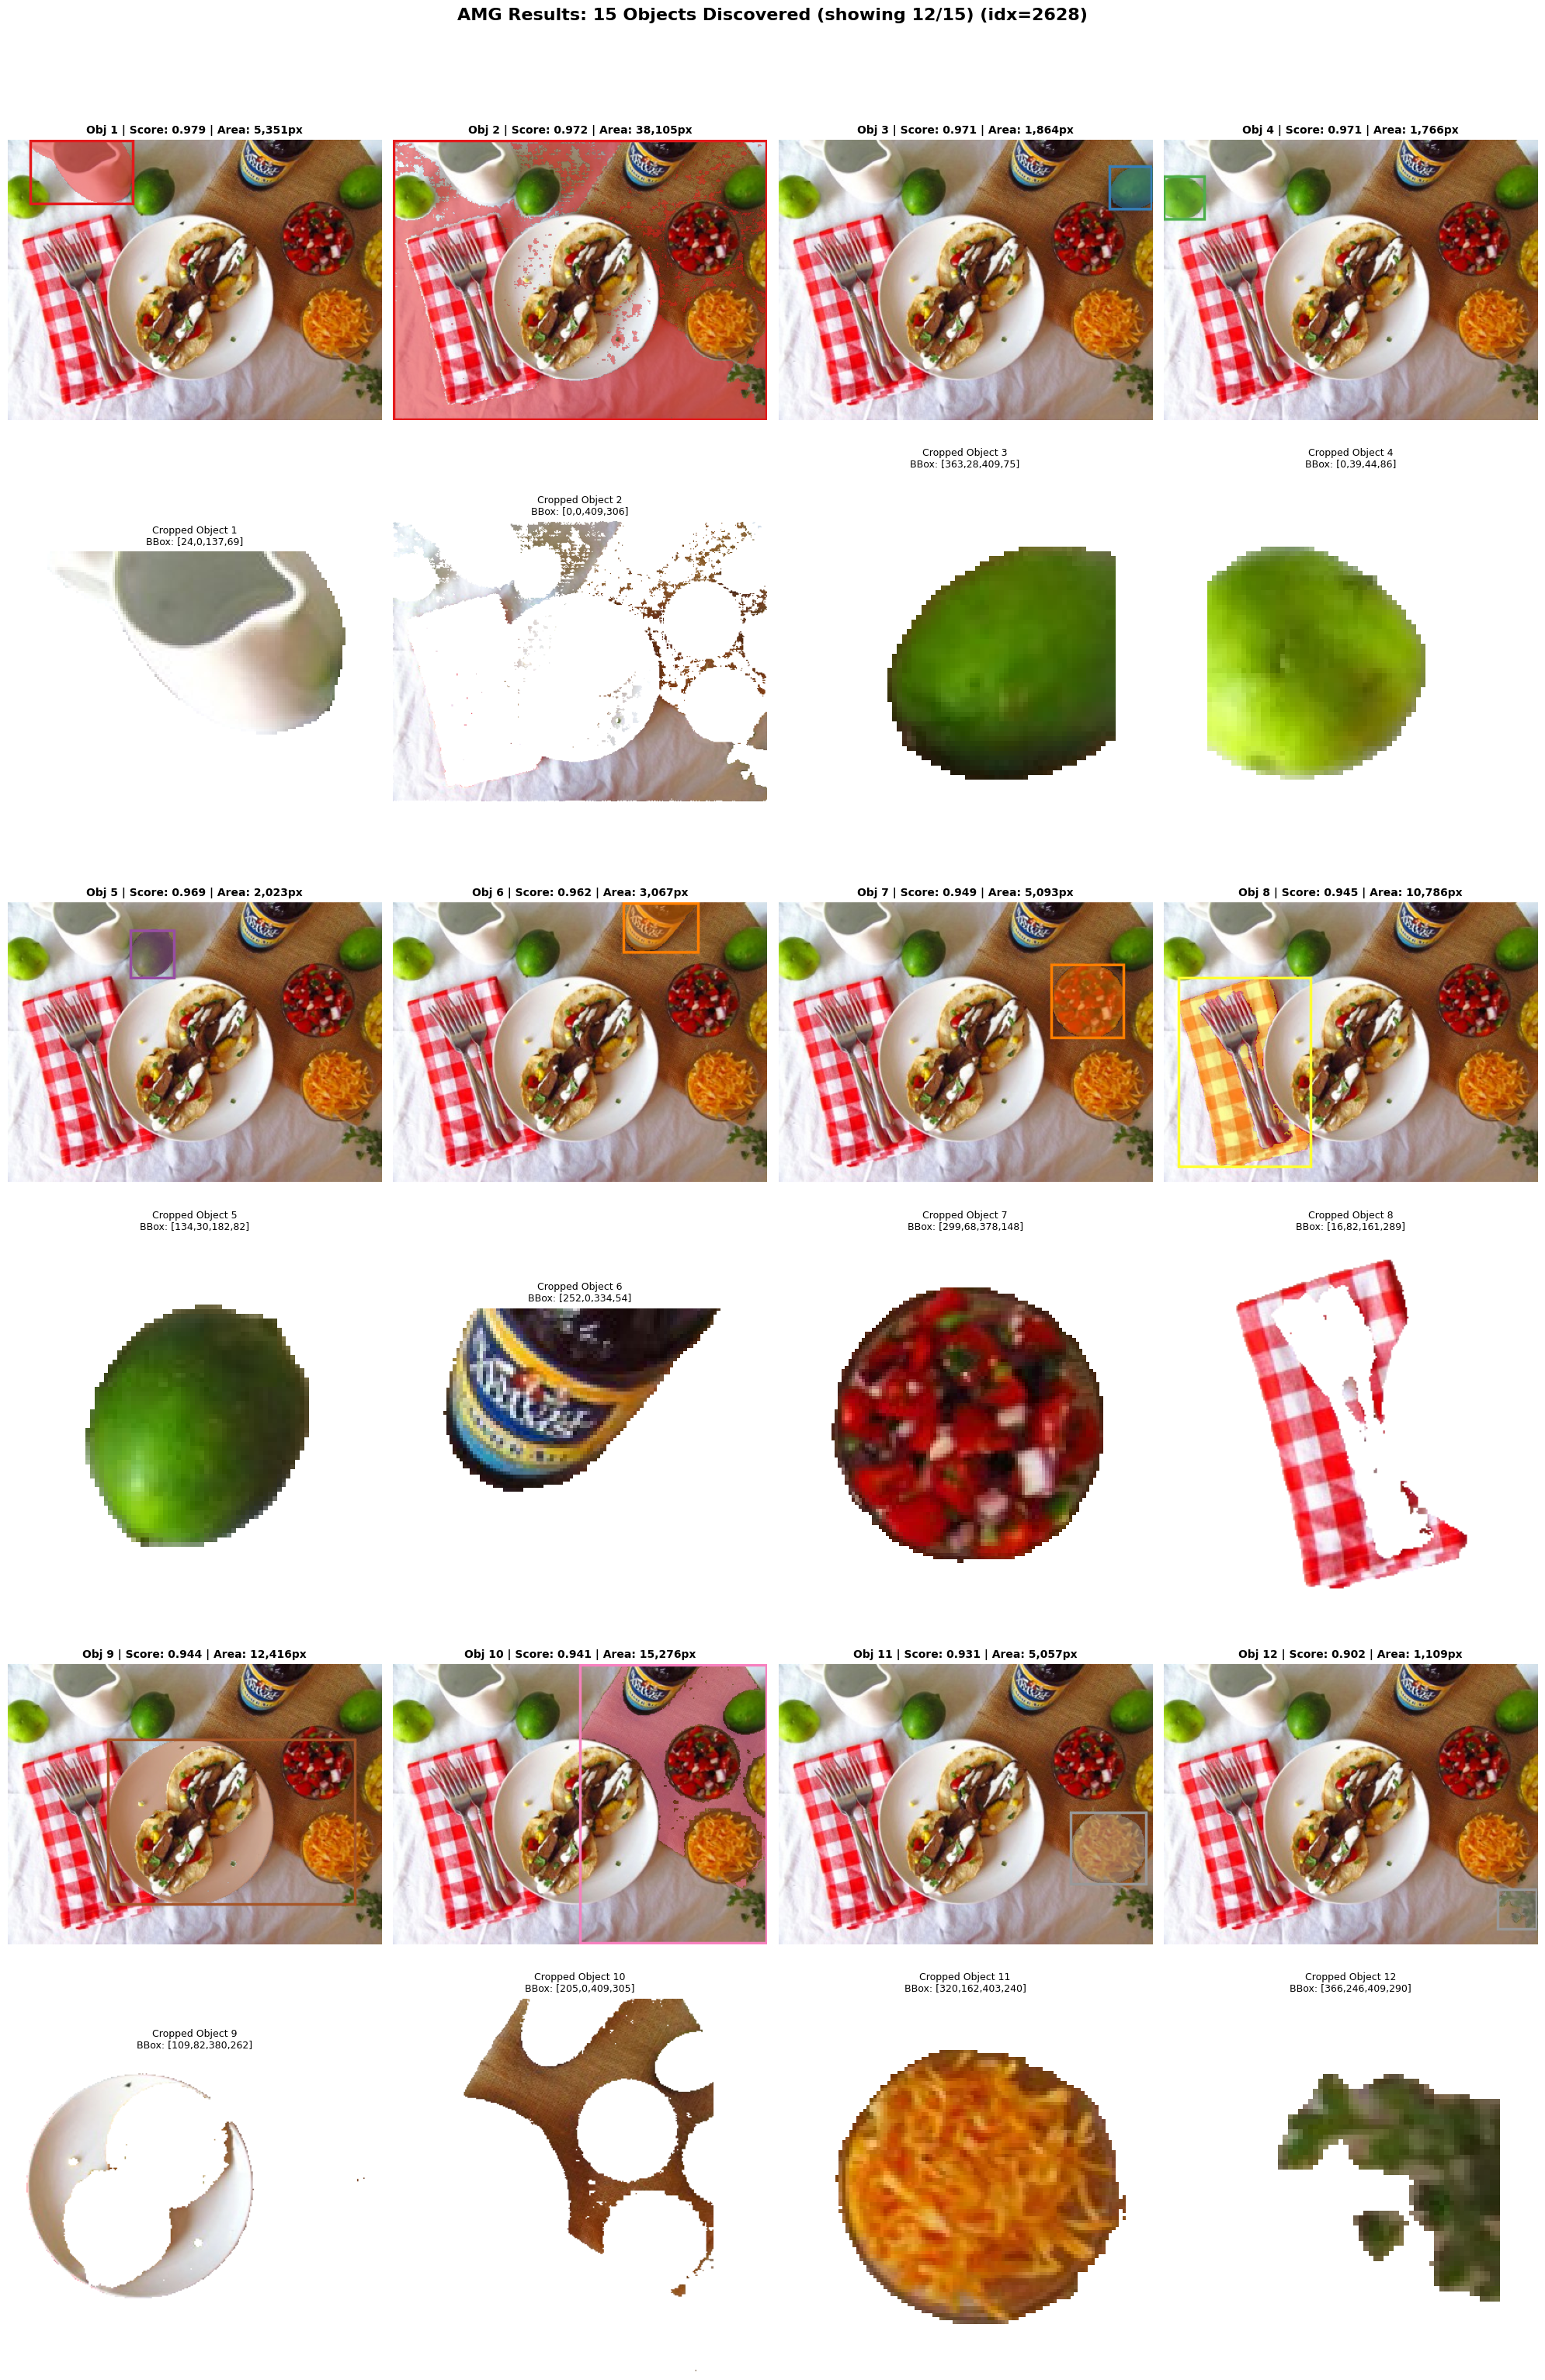

⚠️ Showing 12 of 15 objects (MAX_DISPLAY=12). Increase MAX_DISPLAY to see all.


In [7]:
# --- Display each predicted mask object individually ---
MAX_DISPLAY = 12  # ← Maximum number of objects to display

n_objs = len(amg_results)
n_display = min(n_objs, MAX_DISPLAY)

if n_display > 0:
    cols = min(n_display, 4)
    rows = 2 * ((n_display + cols - 1) // cols)  # 2 rows per object row (mask + crop)

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    if rows == 2 and cols == 1:
        axes = axes.reshape(rows, cols)

    img_array = np.array(image)
    colors = plt.cm.Set1(np.linspace(0, 1, max(n_display, 1)))

    for i, obj in enumerate(amg_results[:n_display]):
        row_base = (i // cols) * 2
        col_idx = i % cols

        # --- Row 1: Mask overlay on original image ---
        ax_mask = axes[row_base, col_idx]
        ax_mask.imshow(image)

        colored_mask = np.zeros((img_h, img_w, 4))
        colored_mask[obj['mask']] = [*colors[i % len(colors)][:3], 0.5]
        ax_mask.imshow(colored_mask)

        x1, y1, x2, y2 = obj['bbox']
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                  linewidth=2.5, edgecolor=colors[i % len(colors)],
                                  facecolor='none')
        ax_mask.add_patch(rect)
        ax_mask.set_title(f"Obj {i+1} | Score: {obj['score']:.3f} | Area: {obj['area']:,}px",
                          fontsize=10, fontweight='bold')
        ax_mask.axis('off')

        # --- Row 2: Cropped object on white background ---
        ax_crop = axes[row_base + 1, col_idx]
        crop_overlay = np.ones_like(img_array) * 255  # white background
        crop_overlay[obj['mask']] = img_array[obj['mask']]

        # Crop to bounding box with padding
        pad = 15
        cx1 = max(0, x1 - pad)
        cy1 = max(0, y1 - pad)
        cx2 = min(img_w, x2 + pad)
        cy2 = min(img_h, y2 + pad)
        cropped = crop_overlay[cy1:cy2, cx1:cx2]

        ax_crop.imshow(cropped)
        ax_crop.set_title(f"Cropped Object {i+1}\nBBox: [{x1},{y1},{x2},{y2}]",
                          fontsize=9)
        ax_crop.axis('off')

    # Hide unused axes
    for r in range(rows):
        for c in range(cols):
            idx = (r // 2) * cols + c
            if idx >= n_display:
                axes[r, c].axis('off')
                axes[r, c].set_visible(False)

    truncated_msg = f" (showing {n_display}/{n_objs})" if n_objs > MAX_DISPLAY else ""
    plt.suptitle(f"AMG Results: {n_objs} Objects Discovered{truncated_msg} (idx={2628})",
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    if n_objs > MAX_DISPLAY:
        print(f"⚠️ Showing {n_display} of {n_objs} objects (MAX_DISPLAY={MAX_DISPLAY}). "
              f"Increase MAX_DISPLAY to see all.")

---
## 5B: Label Each Object with Text Prompts

## 📝 Theory

Now that we have discovered all objects (masks + bounding boxes), we need to
**identify what each object is**. We use SAM 3's PCS (text prompt) mode:

### Labeling Strategy: Crop-and-Score

For each discovered object, we:
1. **Crop** the object region from the image using its bounding box
2. Run SAM 3 PCS with **each candidate label** as a text prompt on the crop
3. The label with the **highest presence score** wins

```
For each discovered object:
  crop = image[bbox]
  for each label in ["egg", "rice", "bread", ...]:
      score = SAM3_PCS(crop, text=label).presence_score
  best_label = argmax(scores)
```

### Optimization: Smart Candidate Selection

Running all 103 food labels per object is slow. We can optimize by:
- Using only the **ground truth classes** present in the image (if available)
- Using a **top-K shortlist** of common food categories
- Or running the full 103 labels for true open-vocabulary discovery

| Strategy | Speed | Accuracy | Use Case |
|---|---|---|---|
| **GT classes only** | ⚡ Fast | Best (oracle) | Validation/benchmarking |
| **Top-30 common** | 🔄 Medium | Good | Quick demo |
| **All 103 classes** | 🐢 Slow | Complete | Full discovery |

In [8]:
# Step 5B.1: Label each AMG object using SAM 3 text prompts

def label_objects_with_text(
    image, amg_results, processor, model, device,
    candidate_labels, pad_ratio=0.1, threshold=0.3
):
    """
    Label each AMG-discovered object using SAM 3 PCS text prompts.

    For each object:
    1. Crop the region (with padding) from the image
    2. Run SAM 3 PCS with each candidate text label
    3. Assign the label with highest presence/detection score

    Args:
        image: PIL Image (RGB)
        amg_results: List of dicts from automatic_mask_generation()
        processor: Sam3Processor (PCS model)
        model: Sam3Model (PCS model)
        device: torch device
        candidate_labels: List of text labels to try (e.g., ["egg", "rice", ...])
        pad_ratio: Padding around bounding box as fraction of box size
        threshold: Minimum score to accept a label

    Returns:
        List of dicts: original AMG result + 'label', 'label_score', 'all_scores'
    """
    img_w, img_h = image.size
    labeled_results = []

    for obj_i, obj in enumerate(amg_results):
        x1, y1, x2, y2 = obj['bbox']

        # Add padding around bounding box
        bw, bh = x2 - x1, y2 - y1
        pad_x = int(bw * pad_ratio)
        pad_y = int(bh * pad_ratio)
        cx1 = max(0, x1 - pad_x)
        cy1 = max(0, y1 - pad_y)
        cx2 = min(img_w, x2 + pad_x)
        cy2 = min(img_h, y2 + pad_y)

        # Crop the object region
        crop = image.crop((cx1, cy1, cx2, cy2))

        # Pre-compute vision features for the crop (run once)
        img_inputs = processor(images=crop, return_tensors="pt").to(device)
        with torch.no_grad():
            vision_embeds = model.get_vision_features(pixel_values=img_inputs.pixel_values)

        # Score each candidate label
        scores_dict = {}
        for label in candidate_labels:
            text_inputs = processor(text=label, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = model(vision_embeds=vision_embeds, input_ids=text_inputs.input_ids)

            # Post-process to get detection results
            results = processor.post_process_instance_segmentation(
                outputs, threshold=0.1, mask_threshold=0.5,
                target_sizes=img_inputs.get("original_sizes").tolist()
            )[0]

            # Use the maximum detection score (0 if nothing found)
            det_scores = results.get('scores', [])
            if len(det_scores) > 0:
                max_score = max(
                    s.item() if torch.is_tensor(s) else s for s in det_scores
                )
            else:
                max_score = 0.0

            scores_dict[label] = max_score

        # Find best label
        best_label = max(scores_dict, key=scores_dict.get)
        best_score = scores_dict[best_label]

        # Apply threshold
        if best_score < threshold:
            best_label = "unknown"

        labeled_obj = {**obj}  # Copy original AMG result
        labeled_obj['label'] = best_label
        labeled_obj['label_score'] = best_score
        labeled_obj['all_scores'] = scores_dict

        labeled_results.append(labeled_obj)

        print(f"   Object {obj_i+1}: '{best_label}' (score: {best_score:.4f})"
              f"  | Top-3: {sorted(scores_dict.items(), key=lambda x: -x[1])[:3]}")

    return labeled_results

In [9]:
# Step 5B.2: Run labeling using ground truth class names as candidates (fast oracle mode)

# Use the ground truth classes for this image as candidates (excluding background)
gt_candidate_labels = [name for name in gt_class_names if name != "background"]

print(f"🏷️  Candidate labels (from GT): {gt_candidate_labels}")
print(f"🔍 Labeling {len(amg_results)} discovered objects...\n")

labeled_objects = label_objects_with_text(
    image, amg_results, processor, model, device,
    candidate_labels=gt_candidate_labels,
    pad_ratio=0.15,
    threshold=0.3
)

print(f"\n✅ Labeling complete!")

🏷️  Candidate labels (from GT): ['lemon', 'steak', 'bread', 'corn', 'asparagus', 'lettuce']
🔍 Labeling 15 discovered objects...

   Object 1: 'lemon' (score: 0.6372)  | Top-3: [('lemon', 0.6372159719467163), ('steak', 0.0), ('bread', 0.0)]
   Object 2: 'lemon' (score: 0.5787)  | Top-3: [('lemon', 0.578678548336029), ('corn', 0.39768263697624207), ('steak', 0.0)]
   Object 3: 'unknown' (score: 0.0000)  | Top-3: [('lemon', 0.0), ('steak', 0.0), ('bread', 0.0)]
   Object 4: 'unknown' (score: 0.0000)  | Top-3: [('lemon', 0.0), ('steak', 0.0), ('bread', 0.0)]
   Object 5: 'unknown' (score: 0.1887)  | Top-3: [('lemon', 0.18868392705917358), ('steak', 0.0), ('bread', 0.0)]
   Object 6: 'unknown' (score: 0.0000)  | Top-3: [('lemon', 0.0), ('steak', 0.0), ('bread', 0.0)]
   Object 7: 'unknown' (score: 0.0000)  | Top-3: [('lemon', 0.0), ('steak', 0.0), ('bread', 0.0)]
   Object 8: 'lemon' (score: 0.8016)  | Top-3: [('lemon', 0.8015649914741516), ('corn', 0.21493566036224365), ('steak', 0.0)]
   

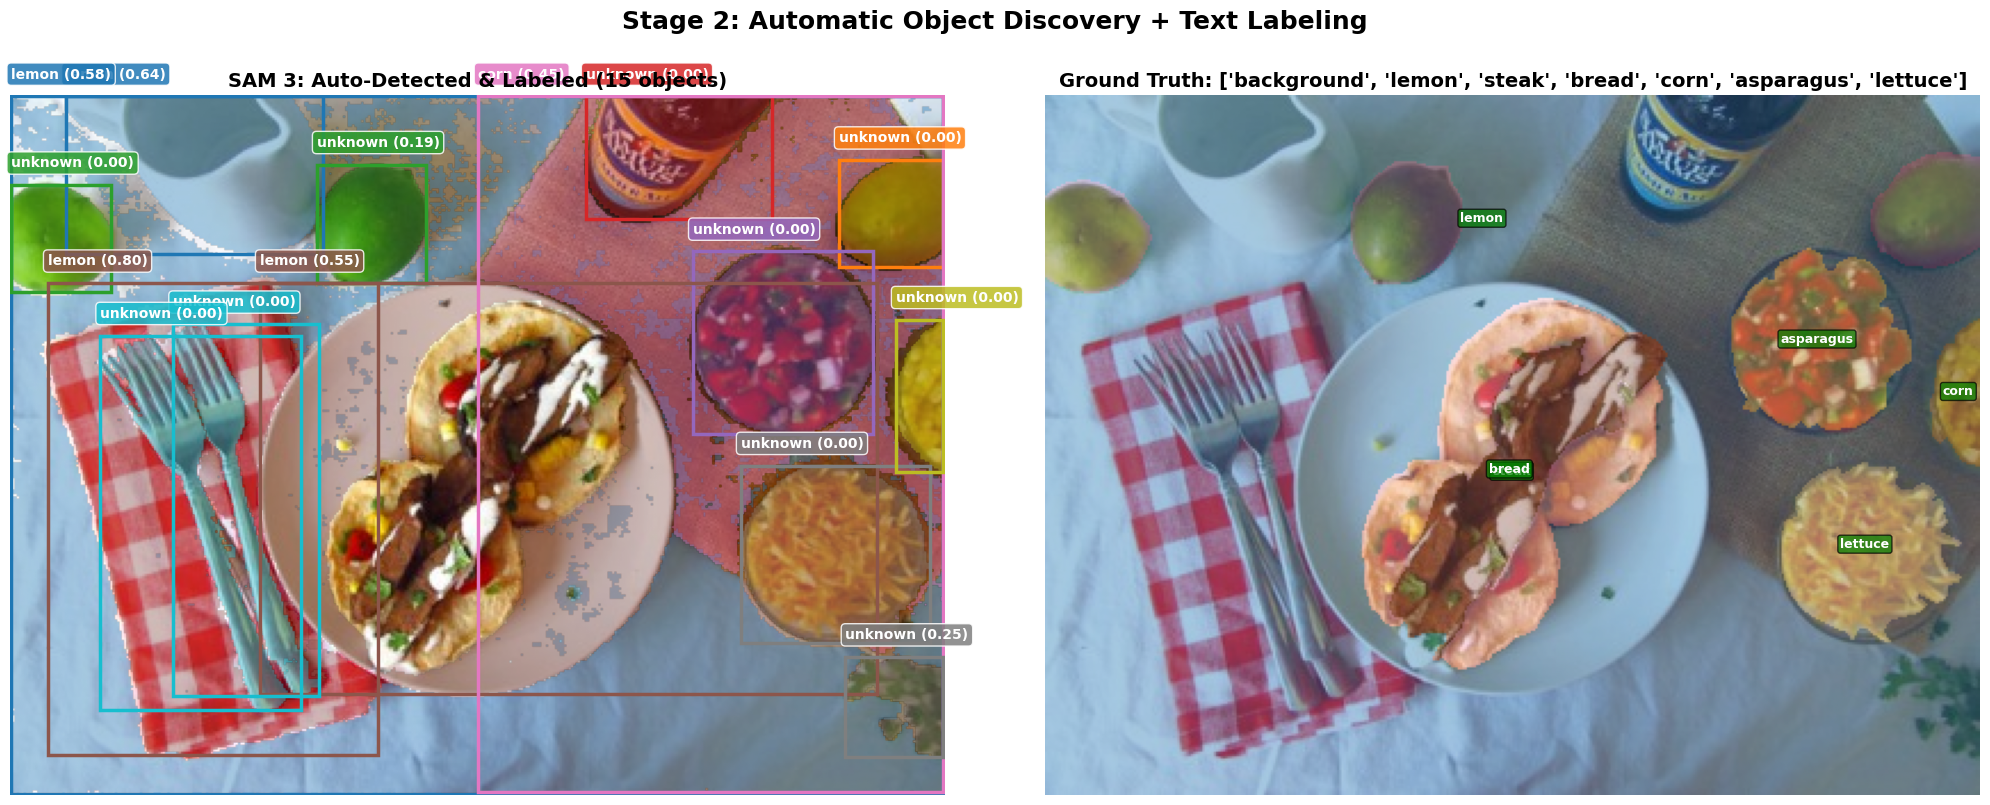

In [10]:
# Step 5B.3: Visualize labeled objects — Full annotated image

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Panel 1: SAM 3 auto-labeled results
axes[0].imshow(image)
colors = plt.cm.tab10(np.linspace(0, 1, max(len(labeled_objects), 1)))

for i, obj in enumerate(labeled_objects):
    # Draw mask overlay
    colored_mask = np.zeros((img_h, img_w, 4))
    colored_mask[obj['mask']] = [*colors[i % len(colors)][:3], 0.4]
    axes[0].imshow(colored_mask)

    # Draw bounding box
    x1, y1, x2, y2 = obj['bbox']
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                              linewidth=2.5,
                              edgecolor=colors[i % len(colors)],
                              facecolor='none')
    axes[0].add_patch(rect)

    # Label text
    label_text = f"{obj['label']} ({obj['label_score']:.2f})"
    axes[0].text(x1, y1 - 8, label_text,
                 fontsize=10, fontweight='bold', color='white',
                 bbox=dict(boxstyle='round,pad=0.3',
                           facecolor=colors[i % len(colors)][:3],
                           alpha=0.85, edgecolor='white'))

axes[0].set_title(f"SAM 3: Auto-Detected & Labeled ({len(labeled_objects)} objects)",
                   fontsize=14, fontweight='bold')
axes[0].axis('off')

# Panel 2: Ground truth
axes[1].imshow(image)
axes[1].imshow(label_array, alpha=0.4, cmap='tab20')

# Add GT class legend
for ci, cname in enumerate(gt_class_names):
    if cname == "background":
        continue
    cid = gt_classes[ci]
    gt_mask = (label_array == cid)
    if gt_mask.sum() > 0:
        ys, xs = np.where(gt_mask)
        cx, cy = int(xs.mean()), int(ys.mean())
        axes[1].text(cx, cy, cname, fontsize=9, fontweight='bold',
                     color='white', ha='center',
                     bbox=dict(boxstyle='round,pad=0.2', facecolor='green', alpha=0.7))

axes[1].set_title(f"Ground Truth: {gt_class_names}", fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.suptitle("Stage 2: Automatic Object Discovery + Text Labeling",
             fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 5C: Full Pipeline — Open Vocabulary Labeling (All 103 Classes)

## 📝 Theory

In a real-world scenario, we don't know which classes are present.
We can run the labeling against a broader set of candidate labels.

To keep it practical, we use a **top-30 common food categories** shortlist
instead of all 103, then show how to extend to the full set.

### Performance Note:
- 10 objects × 30 labels = 300 text prompt inferences
- ~1-2 seconds each on GPU → ~5-10 minutes total
- For 103 labels: ~15-30 minutes (use wisely!)

In [11]:
# Step 5C.1: Define common food label shortlist (top 30)

COMMON_FOOD_LABELS = [
    "egg", "rice", "bread", "noodles", "pasta", "meat", "chicken duck",
    "pork", "steak", "fish", "shrimp", "tofu", "dumpling", "pizza",
    "hamburger", "sausage", "soup", "salad", "tomato", "potato",
    "broccoli", "carrot", "lettuce", "mushroom", "corn", "pepper",
    "cucumber", "onion", "cake", "ice cream", "cheese butter",
    "asparagus", "garlic", "sauce"
]

print(f"🏷️  Common food shortlist: {len(COMMON_FOOD_LABELS)} labels")
print(f"   {COMMON_FOOD_LABELS[:10]} ...")

🏷️  Common food shortlist: 34 labels
   ['egg', 'rice', 'bread', 'noodles', 'pasta', 'meat', 'chicken duck', 'pork', 'steak', 'fish'] ...


In [12]:
# Step 5C.2: Run open-vocabulary labeling with common shortlist

print(f"🔍 Open-vocabulary labeling with {len(COMMON_FOOD_LABELS)} candidate labels...")
print(f"   Objects to label: {len(amg_results)}")
print(f"   Total inferences: {len(amg_results)} × {len(COMMON_FOOD_LABELS)} = "
      f"{len(amg_results) * len(COMMON_FOOD_LABELS)}\n")

labeled_objects_open = label_objects_with_text(
    image, amg_results, processor, model, device,
    candidate_labels=COMMON_FOOD_LABELS,
    pad_ratio=0.15,
    threshold=0.25
)

print(f"\n✅ Open-vocabulary labeling complete!")

🔍 Open-vocabulary labeling with 34 candidate labels...
   Objects to label: 15
   Total inferences: 15 × 34 = 510

   Object 1: 'unknown' (score: 0.0000)  | Top-3: [('egg', 0.0), ('rice', 0.0), ('bread', 0.0)]
   Object 2: 'corn' (score: 0.3977)  | Top-3: [('corn', 0.39768263697624207), ('cheese butter', 0.10598092526197433), ('meat', 0.102960504591465)]
   Object 3: 'unknown' (score: 0.1002)  | Top-3: [('garlic', 0.10023180395364761), ('egg', 0.0), ('rice', 0.0)]
   Object 4: 'unknown' (score: 0.0000)  | Top-3: [('egg', 0.0), ('rice', 0.0), ('bread', 0.0)]
   Object 5: 'unknown' (score: 0.0000)  | Top-3: [('egg', 0.0), ('rice', 0.0), ('bread', 0.0)]
   Object 6: 'unknown' (score: 0.0000)  | Top-3: [('egg', 0.0), ('rice', 0.0), ('bread', 0.0)]
   Object 7: 'unknown' (score: 0.1346)  | Top-3: [('salad', 0.134629487991333), ('egg', 0.0), ('rice', 0.0)]
   Object 8: 'unknown' (score: 0.2149)  | Top-3: [('corn', 0.21493566036224365), ('meat', 0.20289289951324463), ('pepper', 0.130628973245

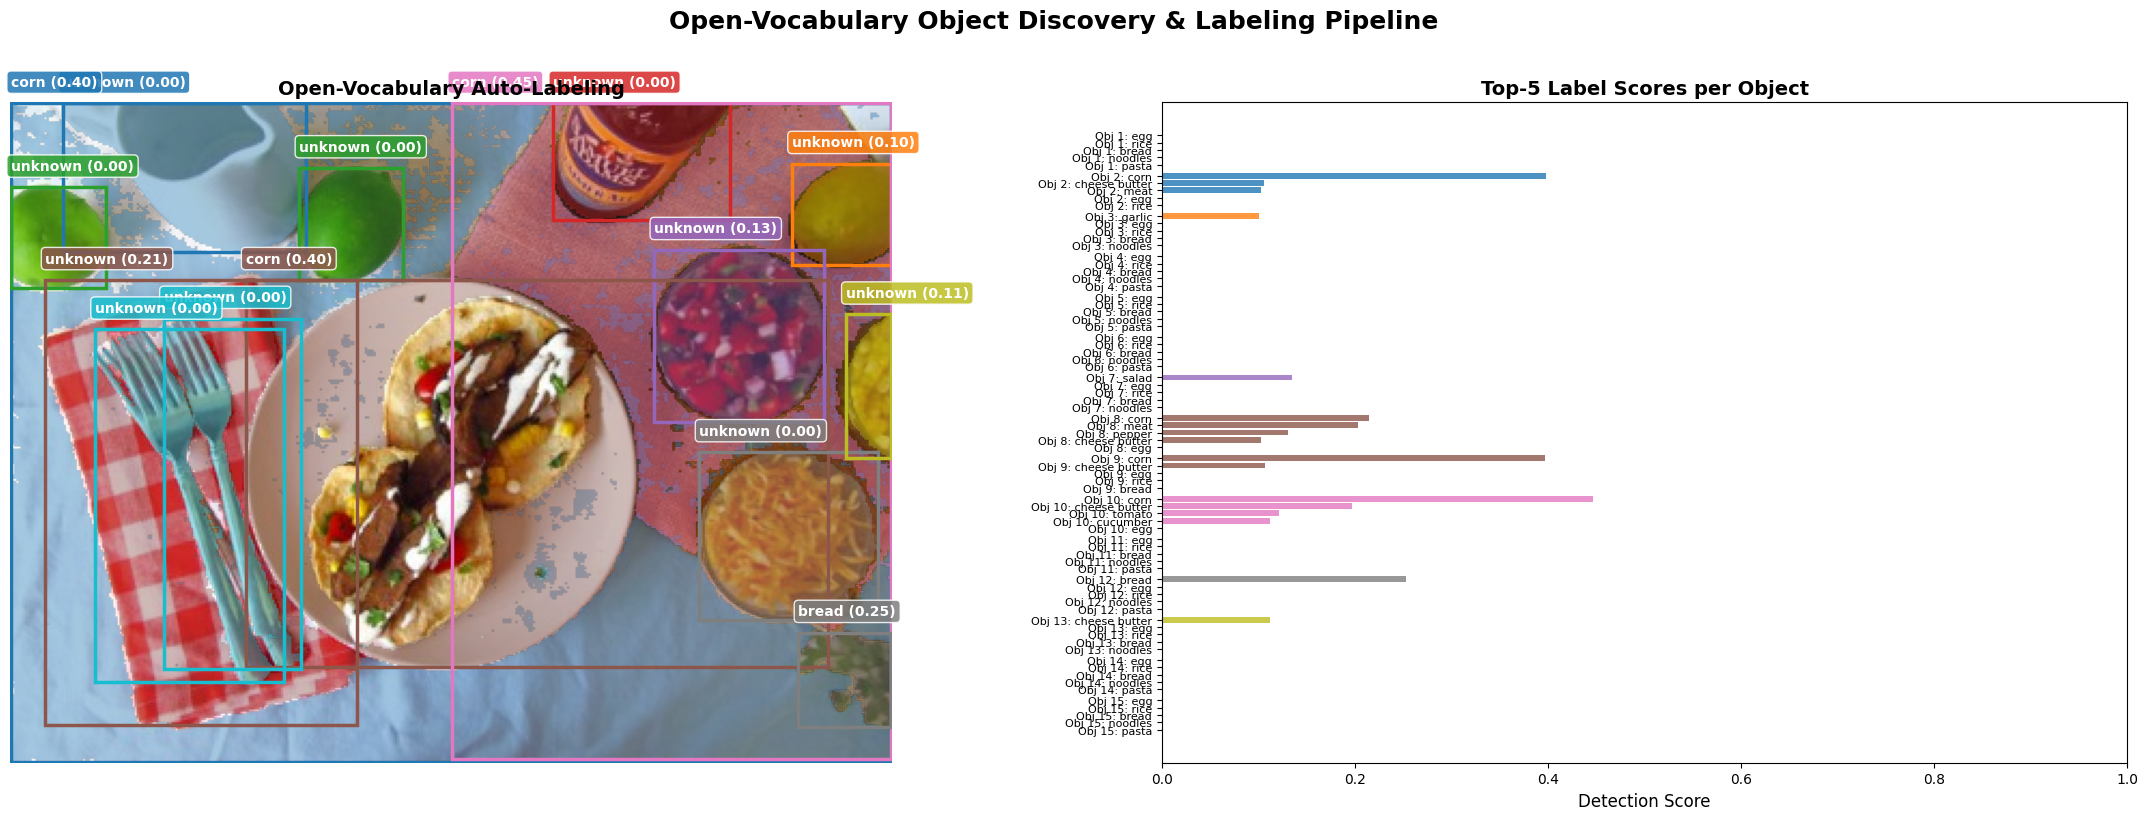

In [13]:
# Step 5C.3: Visualize open-vocabulary results with score breakdown

fig, axes = plt.subplots(1, 2, figsize=(22, 8))

# Panel 1: Labeled image
axes[0].imshow(image)
colors = plt.cm.tab10(np.linspace(0, 1, max(len(labeled_objects_open), 1)))

for i, obj in enumerate(labeled_objects_open):
    colored_mask = np.zeros((img_h, img_w, 4))
    colored_mask[obj['mask']] = [*colors[i % len(colors)][:3], 0.4]
    axes[0].imshow(colored_mask)

    x1, y1, x2, y2 = obj['bbox']
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                              linewidth=2.5, edgecolor=colors[i % len(colors)],
                              facecolor='none')
    axes[0].add_patch(rect)

    label_text = f"{obj['label']} ({obj['label_score']:.2f})"
    axes[0].text(x1, y1 - 8, label_text,
                 fontsize=10, fontweight='bold', color='white',
                 bbox=dict(boxstyle='round,pad=0.3',
                           facecolor=colors[i % len(colors)][:3],
                           alpha=0.85, edgecolor='white'))

axes[0].set_title("Open-Vocabulary Auto-Labeling", fontsize=14, fontweight='bold')
axes[0].axis('off')

# Panel 2: Top-5 scores per object (horizontal bar chart)
n_objs = len(labeled_objects_open)
bar_axes = axes[1]

y_positions = []
y_labels = []
bar_colors_list = []
bar_widths = []
bar_labels = []

y_offset = 0
for i, obj in enumerate(labeled_objects_open):
    sorted_scores = sorted(obj['all_scores'].items(), key=lambda x: -x[1])[:5]
    for rank, (label, score) in enumerate(sorted_scores):
        y_positions.append(y_offset)
        y_labels.append(f"Obj {i+1}: {label}")
        bar_widths.append(score)
        bar_colors_list.append(colors[i % len(colors)][:3])
        y_offset += 1
    y_offset += 0.5  # Gap between objects

bar_axes.barh(y_positions, bar_widths, color=bar_colors_list, height=0.8, alpha=0.8)
bar_axes.set_yticks(y_positions)
bar_axes.set_yticklabels(y_labels, fontsize=8)
bar_axes.set_xlabel("Detection Score", fontsize=12)
bar_axes.set_title("Top-5 Label Scores per Object", fontsize=14, fontweight='bold')
bar_axes.invert_yaxis()
bar_axes.set_xlim(0, 1.0)

plt.suptitle("Open-Vocabulary Object Discovery & Labeling Pipeline",
             fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [14]:
# Step 5C.4: Summary table — Predicted vs Ground Truth

print(f"\n{'='*80}")
print(f"📊 FINAL RESULTS: Auto-Discovery + Labeling")
print(f"{'='*80}")
print(f"Ground Truth Classes: {gt_class_names}")
print(f"Objects Discovered: {len(labeled_objects_open)}")
print()

print(f"{'Obj':<5} {'Predicted Label':<20} {'Score':<8} {'Area':<10} {'BBox':<25}")
print("-" * 68)
for i, obj in enumerate(labeled_objects_open):
    print(f"{i+1:<5} {obj['label']:<20} {obj['label_score']:<8.4f} "
          f"{obj['area']:<10,} {str(obj['bbox']):<25}")

# Compare predicted labels vs ground truth
predicted_labels = set(obj['label'] for obj in labeled_objects_open if obj['label'] != 'unknown')
gt_labels = set(name for name in gt_class_names if name != 'background')

print(f"\n🎯 Label Comparison:")
print(f"   Ground Truth labels : {gt_labels}")
print(f"   Predicted labels    : {predicted_labels}")
print(f"   Correctly found     : {gt_labels & predicted_labels}")
print(f"   Missed (FN)         : {gt_labels - predicted_labels}")
print(f"   Extra (FP)          : {predicted_labels - gt_labels}")

recall = len(gt_labels & predicted_labels) / len(gt_labels) if gt_labels else 0
precision = len(gt_labels & predicted_labels) / len(predicted_labels) if predicted_labels else 0
print(f"\n   Label Recall:    {recall:.2%}")
print(f"   Label Precision: {precision:.2%}")


📊 FINAL RESULTS: Auto-Discovery + Labeling
Ground Truth Classes: ['background', 'lemon', 'steak', 'bread', 'corn', 'asparagus', 'lettuce']
Objects Discovered: 15

Obj   Predicted Label      Score    Area       BBox                     
--------------------------------------------------------------------
1     unknown              0.0000   5,351      [24, 0, 137, 69]         
2     corn                 0.3977   38,105     [0, 0, 409, 306]         
3     unknown              0.1002   1,864      [363, 28, 409, 75]       
4     unknown              0.0000   1,766      [0, 39, 44, 86]          
5     unknown              0.0000   2,023      [134, 30, 182, 82]       
6     unknown              0.0000   3,067      [252, 0, 334, 54]        
7     unknown              0.1346   5,093      [299, 68, 378, 148]      
8     unknown              0.2149   10,786     [16, 82, 161, 289]       
9     corn                 0.3972   12,416     [109, 82, 380, 262]      
10    corn                 0.4468   1

---
## 5D: Run on Multiple Images — Batch Evaluation

Let's test the full pipeline on several different food images.

In [ ]:
# Step 5D.1: Run full pipeline on 3 random images

import random

test_indices = [2628, 1718, 3764]  # Mix of different food combinations
print(f"🔬 Running full pipeline on {len(test_indices)} images...\n")

for img_idx in test_indices:
    sample = ds[img_idx]
    image = sample['image'].convert("RGB")
    img_w, img_h = image.size
    label_array = np.array(sample['label'])
    gt_classes = sample['classes_on_image']
    gt_class_names = [FOODSEG103_LABELS.get(c, f"class_{c}") for c in gt_classes]

    print(f"\n{'='*60}")
    print(f"📸 Image {img_idx} | Size: {img_w}x{img_h}")
    print(f"   GT classes: {gt_class_names}")

    # Stage 1: AMG
    amg = automatic_mask_generation(
        image, tracker_processor, tracker_model, device,
        points_per_side=12, pred_iou_thresh=0.80,
        min_mask_region_area=400, nms_iou_thresh=0.5
    )

    if len(amg) == 0:
        print("   ⚠️ No objects found, skipping...")
        continue

    # Stage 2: Label with GT candidates (fast mode)
    gt_candidates = [n for n in gt_class_names if n != "background"]
    labeled = label_objects_with_text(
        image, amg, processor, model, device,
        candidate_labels=gt_candidates,
        pad_ratio=0.15, threshold=0.25
    )

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].imshow(image)
    vis_colors = plt.cm.tab10(np.linspace(0, 1, max(len(labeled), 1)))
    for i, obj in enumerate(labeled):
        colored_mask = np.zeros((img_h, img_w, 4))
        colored_mask[obj['mask']] = [*vis_colors[i % len(vis_colors)][:3], 0.4]
        axes[0].imshow(colored_mask)
        x1, y1, x2, y2 = obj['bbox']
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                                  edgecolor=vis_colors[i % len(vis_colors)], facecolor='none')
        axes[0].add_patch(rect)
        axes[0].text(x1, y1-5, f"{obj['label']} ({obj['label_score']:.2f})",
                     fontsize=9, color='white', fontweight='bold',
                     bbox=dict(boxstyle='round,pad=0.2',
                               facecolor=vis_colors[i % len(vis_colors)][:3], alpha=0.85))
    axes[0].set_title(f"SAM 3 Auto-Labeled ({len(labeled)} objects)", fontsize=13, fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(image)
    axes[1].imshow(label_array, alpha=0.4, cmap='tab20')
    axes[1].set_title(f"Ground Truth: {gt_class_names}", fontsize=11)
    axes[1].axis('off')

    plt.suptitle(f"Image idx={img_idx}: Auto Discovery + Labeling",
                 fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.show()

🔬 Running full pipeline on 3 images...


📸 Image 2628 | Size: 512x384
   GT classes: ['background', 'egg', 'raspberry', 'bread']
🔍 AMG: Sampling 144 grid points (12x12)...


---
## 📝 Lab 5 Summary

### What We Learned:

| Concept | Description |
|---|---|
| **Automatic Mask Generation (AMG)** | Grid-based point sampling → find ALL objects without any prompt |
| **Non-Maximum Suppression (NMS)** | Remove duplicate/overlapping masks to get clean object set |
| **Crop-and-Score Labeling** | Crop each object → run text prompts → highest score = label |
| **Two-Stage Pipeline** | AMG (find) → PCS (label) = complete object discovery |
| **Candidate Optimization** | Use GT labels (oracle), common shortlist, or full 103 classes |

### Pipeline Summary:
```
Image
  │
  ▼
┌──────────────────────────┐
│ Stage 1: AMG             │
│ • Grid point sampling    │
│ • Score filtering        │
│ • NMS deduplication      │
│ → N object masks + boxes │
└──────────┬───────────────┘
           │
           ▼
┌──────────────────────────┐
│ Stage 2: Text Labeling   │
│ • Crop each object       │
│ • Score all candidates   │
│ • Assign best label      │
│ → Labeled objects        │
└──────────┬───────────────┘
           │
           ▼
┌──────────────────────────┐
│ Output: Annotated Image  │
│ • Masks + Boxes + Labels │
│ • Confidence scores      │
│ • Comparison with GT     │
└──────────────────────────┘
```

### 🔑 Key Takeaways:
1. **SAM 3 can discover objects it wasn't explicitly asked about** — true open-vocabulary
2. **AMG + PCS is a powerful combination** for automatic annotation pipelines
3. **The presence token** helps reduce false positives during text labeling
4. **Trade-off: speed vs completeness** — more candidate labels = slower but more accurate
5. This pipeline can be used for **auto-labeling training data** in production ML systems

### 🚀 Extensions:
- Run on video frames for temporal object tracking + labeling
- Use image exemplar prompts instead of text for domain-specific objects
- Combine with a lightweight classifier on the crops for faster labeling
- Export labeled masks in COCO format for training other models

In [ ]:
print("✅ Lab 5 Complete! Full object discovery + labeling pipeline demonstrated.")